In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import xarray as xr
import scipy.io

SARTA output from Sergio

Load SARTA

In [8]:
sarta_out = "sarta_333profiles.mat"

sarta_hdf = scipy.io.loadmat(sarta_out)

In [9]:
sarta_hdf.keys()

dict_keys(['__header__', '__version__', '__globals__', 'comment', 'fx', 'rx', 'tx'])

In [20]:
sarta_hdf["rx"].shape

(2645, 333)

In [59]:
l1c_indices = np.arange(1, 2645 + 1)

wnum_da = xr.DataArray(sarta_hdf["fx"][:,0], dims=["wnum"], coords={"wnum": sarta_hdf["fx"][:,0]})
wnum_da.name="freq"

da_list = [wnum_da]
for _var in ["rx", "tx"]:
    da = xr.DataArray(sarta_hdf[_var][:,:], dims=["wnum", "time"], coords={"wnum": wnum_da, "time": np.arange(0, 333)})
    da.name = _var
    da_list.append(da)
    
sarta_ds = xr.merge(da_list)

Load COSP-RTTOV

In [55]:
rttov_out = "sarta_input.nc"

rttov_ds = xr.open_dataset(rttov_out).rename({"RTTOV_CHAN_I001":"wnum"})
rttov_ds["wnum"] = sarta_hdf["fx"][:,0]

In [50]:
wnum_da2 = xr.DataArray(sarta_hdf["fx"][:,0], dims=["RTTOV_CHAN_I001"], coords={"RTTOV_CHAN_I001": rttov_ds["RTTOV_CHAN_I001"]})

rttov_ds = rttov_ds.assign_coords({"wnum":wnum_da2})

#### Reproduce Sergio's comparison

This is not what Sergio saw, am I fairly comparing the profiles?

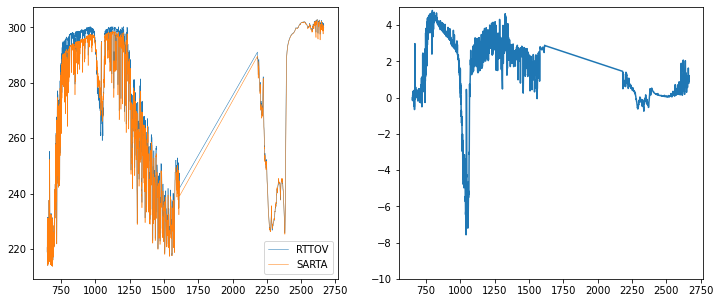

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs = axs.flat

ax = axs[0]

data_rttov = rttov_ds["rttov_bt_clear_inst001"].mean(dim="time")
ax.plot(
    data_rttov.wnum,
    data_rttov,
    label="RTTOV",
    linewidth=0.5,
)

data_sarta = sarta_ds["tx"].mean(dim="time")
ax.plot(
    data_sarta.wnum,
    data_sarta,
    label="SARTA",
    linewidth=0.5,
)

ax = axs[1]

diff = data_rttov - data_sarta
ax.plot(diff.wnum, diff)
ax.set_ylim(-10, 5)

# rttov_ds["rttov_bt_clear_inst001"].isel(time=0).plot(label="rttov")

# sarta_ds["tx"].isel(time=0).plot(label="sarta")

axs[0].legend()

Single Profile

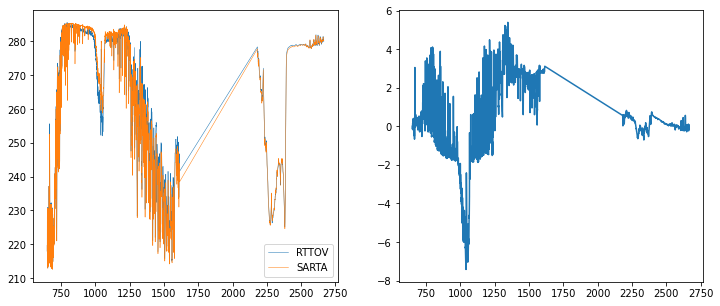

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs = axs.flat

ax = axs[0]

data_rttov = rttov_ds["rttov_bt_clear_inst001"].isel(time=0)
ax.plot(
    data_rttov.wnum,
    data_rttov,
    label="RTTOV",
    linewidth=0.5,
)

data_sarta = sarta_ds["tx"].isel(time=0)
ax.plot(
    data_sarta.wnum,
    data_sarta,
    label="SARTA",
    linewidth=0.5,
)

ax = axs[1]

diff = data_rttov - data_sarta
ax.plot(diff.wnum, diff)

# rttov_ds["rttov_bt_clear_inst001"].isel(time=0).plot(label="rttov")

# sarta_ds["tx"].isel(time=0).plot(label="sarta")

axs[0].legend()

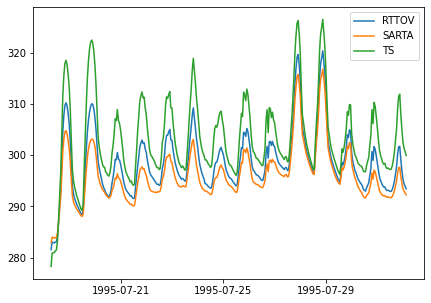

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

data_rttov = rttov_ds["rttov_bt_clear_inst001"].sel(wnum=1230.8092)
data_sarta = sarta_ds["tx"].sel(wnum=1230.8092)

data_skt = rttov_ds["TS"]

ax.plot(
    data_rttov.time,
    data_rttov,
    label="RTTOV"
)

ax.plot(
    data_rttov.time,
    data_sarta,
    label="SARTA"
)

ax.plot(
    data_rttov.time,
    data_skt,
    label="TS"
)

plt.legend()

# sarta_ds["tx"].sel(wnum=1230.8092).plot()

Weird, this is not what I expected if TS was shifted by a timestep...clearly RTTOV and SARTA have different transmissivities, even in this window region. Or they are just seeing different TS values entirely.

The only reelvant variables in this channel are TS and H2O. So those are my leads for tomorrow.

Water vapor units?? kg/kg vs. vmr?

In [71]:
rttov_ds["rttov_bt_clear_inst001"].sel(wnum=1231, method="nearest")

<xarray.DataArray 'rttov_bt_clear_inst001' (time: 333)>
array([281.54422, 283.01978, 282.9656 , ..., 294.4365 , 293.9379 , 293.43405],
      dtype=float32)
Coordinates:
  * time     (time) object 1995-07-18 06:50:00 ... 1995-08-01 02:50:00
    lat      float64 36.61
    lon      float64 262.5
    wnum     float32 1.231e+03
Attributes:
    mdims:         5
    units:         Degrees Kelvin
    long_name:     RTTOV Clear-sky Brightness Temperature
    cell_methods:  time: mean

In [83]:
rttov_ds["ozone"]

<xarray.DataArray 'ozone' (time: 333, lev: 33)>
array([[2.579354e-06, 6.625365e-06, 8.349693e-06, ..., 3.859881e-08,
        3.641335e-08, 3.641335e-08],
       [2.579449e-06, 6.625610e-06, 8.349853e-06, ..., 3.857173e-08,
        3.641562e-08, 3.641562e-08],
       [2.579544e-06, 6.625854e-06, 8.350013e-06, ..., 3.860290e-08,
        3.641789e-08, 3.641789e-08],
       ...,
       [2.606013e-06, 6.693841e-06, 8.364573e-06, ..., 3.871176e-08,
        3.624626e-08, 3.624626e-08],
       [2.606136e-06, 6.694158e-06, 8.364560e-06, ..., 3.890343e-08,
        3.624445e-08, 3.624445e-08],
       [2.606260e-06, 6.694475e-06, 8.364547e-06, ..., 3.908626e-08,
        3.624265e-08, 3.624265e-08]], dtype=float32)
Coordinates:
  * lev      (lev) float64 1.128 3.643 7.595 14.36 ... 936.2 957.5 976.3 992.6
  * time     (time) object 1995-07-18 06:50:00 ... 1995-08-01 02:50:00
    lat      float64 36.61
    lon      float64 262.5

In [58]:
diff

<xarray.DataArray (wnum: 2645, channel: 2645)>
array([[ 4.6081543e-03,  1.7141724e+00, -8.5926819e-01, ...,
        -6.0766815e+01, -6.0620331e+01, -6.0529510e+01],
       [-1.8553925e+00, -1.4582825e-01, -2.7192688e+00, ...,
        -6.2626816e+01, -6.2480331e+01, -6.2389511e+01],
       [ 8.3863831e-01,  2.5482025e+00, -2.5238037e-02, ...,
        -5.9932785e+01, -5.9786301e+01, -5.9695480e+01],
       ...,
       [ 6.0861603e+01,  6.2571167e+01,  5.9997726e+01, ...,
         9.0179443e-02,  2.3666382e-01,  3.2748413e-01],
       [ 6.0574280e+01,  6.2283844e+01,  5.9710403e+01, ...,
        -1.9714355e-01, -5.0659180e-02,  4.0161133e-02],
       [ 6.0409760e+01,  6.2119324e+01,  5.9545883e+01, ...,
        -3.6166382e-01, -2.1517944e-01, -1.2435913e-01]], dtype=float32)
Coordinates:
    lat      float64 36.61
    lon      float64 262.5
  * wnum     (wnum) float32 649.6 649.9 650.1 ... 2.663e+03 2.664e+03 2.665e+03
  * channel  (channel) int64 1 2 3 4 5 6 7 ... 2640 2641 2642 2643 2644 2645

In [41]:
sarta_hdf["tx"].shape

(2645, 333)

In [12]:
sarta_hdf["tx"].shape

(2645, 333)

#### Jacobians from Sergio

In [370]:
jacobian_files = [
    'jacobians_SAS.mat', # done
    'jacobians_STD.mat', # done
    'jacobians_TRP.mat', # done
    'jacobians_SAW.mat', # done
    'jacobians_MLS.mat', # done
    'jacobians_MLW.mat',
]

In [371]:
test_jac_file = "jacobians_STD.mat"

test = h5py.File(test_jac_file, 'r')

In [372]:
test.keys()

<KeysViewHDF5 ['bt', 'co2jac', 'efreq', 'emis', 'f', 'findx', 'mmw', 'o3jac', 'plays', 'rad', 'skt', 'sktjac', 'tjac', 'wgtfcn', 'wvjac']>

In [373]:
# Read the Jacobians into xarray for easy manipulating.
pres = test["plays"][0, :]
l1c_indices = np.arange(1, 2645 + 1)

wnum_da = xr.DataArray(test["f"][0,:], dims=["channel"], coords={"channel": l1c_indices})
wnum_da.name="freq"
# wnum_da = xr.DataArray(sergio_chan_wns, dims=["channel"], coords={"channel": l1c_indices})

da_list = [wnum_da]
for i in test.keys():
    
    # Case without vertical dimension
    if test[i].shape == (1, 2645):
        da = xr.DataArray(test[i][0,:], dims=["channel"], coords={"wnum": wnum_da})
        da.name = i
        da_list.append(da)
    # Case with vertical dimension
    if test[i].shape == (97, 2645):
        da = xr.DataArray(test[i][:,:], dims=["play", "channel"], coords={"wnum": wnum_da, "play": pres})
        da.name = i
        da_list.append(da)
#     break

jac_ds = xr.merge(da_list)

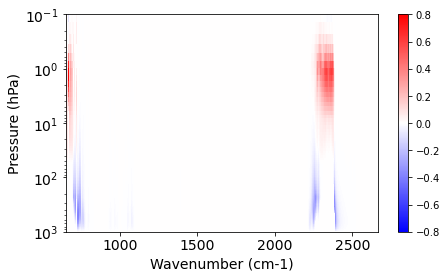

In [374]:
var = "co2jac"

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
im = plt.pcolormesh(
    jac_ds[var].wnum,
    jac_ds[var].play,
    jac_ds[var],
    cmap="bwr", #coolwarm
    vmin=-0.8,
    vmax=0.8,
)

ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)

plt.colorbar(im)

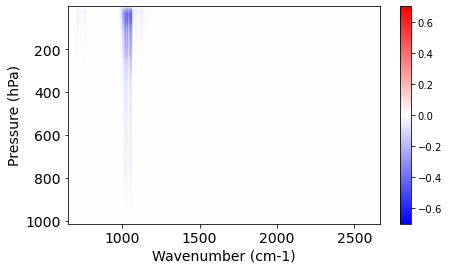

In [375]:
var = "o3jac"

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.invert_yaxis()
im = plt.pcolormesh(
    jac_ds[var].wnum,
    jac_ds[var].play,
    jac_ds[var],
    cmap="bwr", #coolwarm
    vmin=-0.7,
    vmax=0.7,
)

ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)

plt.colorbar(im)

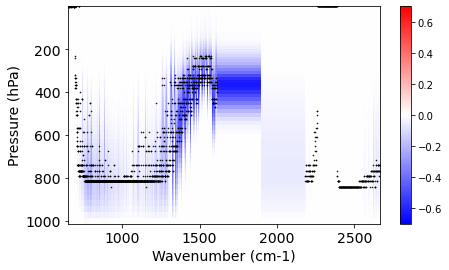

In [376]:
var = "wvjac"

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.invert_yaxis()
im = plt.pcolormesh(
    jac_ds[var].wnum,
    jac_ds[var].play,
    jac_ds[var],
    cmap="bwr", #coolwarm
    vmin=-0.7,
    vmax=0.7,
)

# Does not work
max_lev = jac_ds["play"][np.abs(jac_ds[var]).argmax(dim="play")]
plt.scatter(max_lev.wnum, max_lev, s=0.3, color="black")

ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)

plt.colorbar(im)

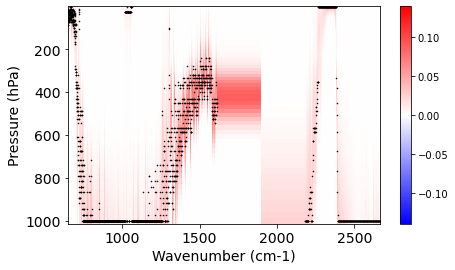

In [377]:
var = "tjac"

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.invert_yaxis()
im = plt.pcolormesh(
    jac_ds[var].wnum,
    jac_ds[var].play,
    jac_ds[var],
    cmap="bwr", #coolwarm
    vmin=-0.14,
    vmax=0.14,
)

# Does not work
max_lev = jac_ds["play"][np.abs(jac_ds[var]).argmax(dim="play")]
plt.scatter(max_lev.wnum, max_lev, s=0.3, color="black")

ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)

plt.colorbar(im)

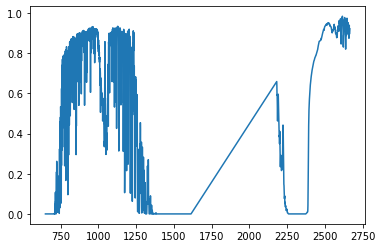

In [378]:
plt.plot(jac_ds["sktjac"].wnum, jac_ds["sktjac"]) #.plot()

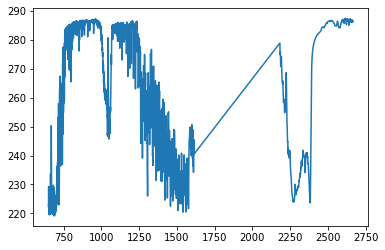

In [379]:
plt.plot(jac_ds["bt"].wnum, jac_ds["bt"])

Compute peak of the weighting function.

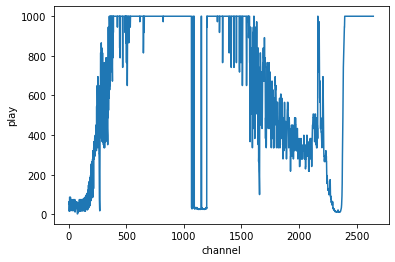

In [380]:
jac_ds["play"][jac_ds["wgtfcn"].argmax(dim="play")].plot()

#### Just for simulated channels

Weighting function peak

In [381]:
rttov_channels = jac_ds.sel(channel=l1c_channels)

In [382]:
weightingfunction_peak_rttov = rttov_channels["play"][rttov_channels["wgtfcn"].argmax(dim="play")]

CO2 channels are roughly channels 1-400. Which is the first 8 that I simulated.

In [383]:
co2_channels = rttov_channels.isel(channel=slice(None, 8))

In [384]:
strato_channels = rttov_channels.isel(channel=slice(None, 3))

In [385]:
tropo_channels = rttov_channels.isel(channel=slice(3,8))

In [386]:
t_channels = rttov_channels.isel(channel=slice(8, 17))

In [387]:
o3_channels = rttov_channels.isel(channel=slice(15, 21))

In [388]:
window_channels = rttov_channels.isel(channel=slice(21, 24))

In [389]:
h2o_t_channels = rttov_channels.isel(channel=slice(24, 33))

Print peak of weighting function

In [390]:
for _chan in weightingfunction_peak_rttov:
    print(_chan.values)

41.148433685302734
11.807397842407227
27.625919342041016
195.60592651367188
351.23614501953125
672.3671264648438
415.9138488769531
695.053955078125
999.94189453125
918.13037109375
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
30.67068099975586
999.94189453125
27.625919342041016
24.792694091796875
27.625919342041016
999.94189453125
999.94189453125
999.94189453125
672.3671264648438
765.6452026367188
336.0909118652344
565.2844848632812
321.35107421875
487.23565673828125
399.1257629394531
293.07720947265625
433.1174011230469
999.94189453125
918.13037109375
944.9931030273438
840.0158081054688
487.23565673828125
628.2637939453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125


Print peak of Jacobians

In [391]:
max_lev_co2 = rttov_channels["play"][np.abs(rttov_channels["co2jac"]).argmax(dim="play")]

In [392]:
for i,_lev in enumerate(max_lev_co2):
    print(_lev.values)
    if i == 7: 
        break

3.696155548095703
3.696155548095703
4.48549222946167
229.28704833984375
293.07720947265625
415.9138488769531
321.35107421875
433.1174011230469


In [393]:
max_lev_t = rttov_channels["play"][np.abs(rttov_channels["tjac"]).argmax(dim="play")]

In [394]:
for _lev in max_lev_t:
    print(_lev.values)

37.42461013793945
10.239742279052734
27.625919342041016
293.07720947265625
433.1174011230469
790.01611328125
506.11474609375
741.6934814453125
999.94189453125
972.2648315429688
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
24.792694091796875
24.792694091796875
27.625919342041016
999.94189453125
999.94189453125
999.94189453125
741.6934814453125
790.01611328125
366.7889404296875
585.8536376953125
336.0909118652344
506.11474609375
433.1174011230469
321.35107421875
468.77691650390625
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
972.2648315429688
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125
999.94189453125


In [395]:
max_lev_o3 = rttov_channels["play"][np.abs(o3_channels["o3jac"]).argmax(dim="play")]

In [396]:
for _lev in max_lev_o3:
    print(_lev.values)

37.42461013793945
37.42461013793945
41.148433685302734
37.42461013793945
41.148433685302734
41.148433685302734


In [397]:
max_lev_wv = rttov_channels["play"][np.abs(h2o_t_channels["wvjac"]).argmax(dim="play")]

In [398]:
for _lev in max_lev_wv:
    print(_lev.values)

585.8536376953125
672.3671264648438
336.0909118652344
506.11474609375
293.07720947265625
433.1174011230469
366.7889404296875
279.5373840332031
382.75152587890625


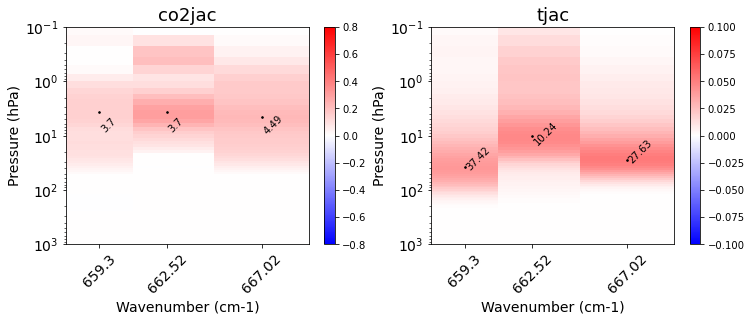

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flat

data = strato_channels

ax = axs[0]
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "co2jac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.8,
    vmax=0.8,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 
    print(_lev.values)
print("")

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

ax = axs[1]
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "tjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.1,
    vmax=0.1,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 
    print(_lev.values)

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

229.28704833984375
293.07720947265625
415.9138488769531
321.35107421875
433.1174011230469

293.07720947265625
433.1174011230469
790.01611328125
506.11474609375
741.6934814453125


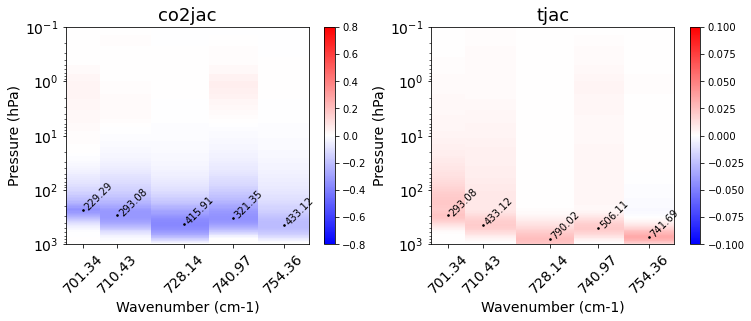

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flat

data = tropo_channels

ax = axs[0]
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "co2jac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.8,
    vmax=0.8,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45)
    print(_lev.values)
print("")

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

ax = axs[1]
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "tjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.1,
    vmax=0.1,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 
    print(_lev.values)

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

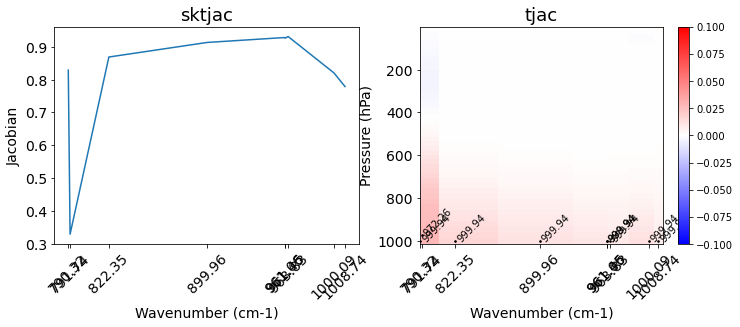

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flat

data = t_channels

ax = axs[0]
# ax.invert_yaxis()
var = "sktjac"
im = ax.plot(
    data[var].wnum,
    data[var],
)

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Jacobian", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)

ax = axs[1]
ax.invert_yaxis()
var = "tjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.1,
    vmax=0.1,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

# co2_channels["co2jac"].plot()

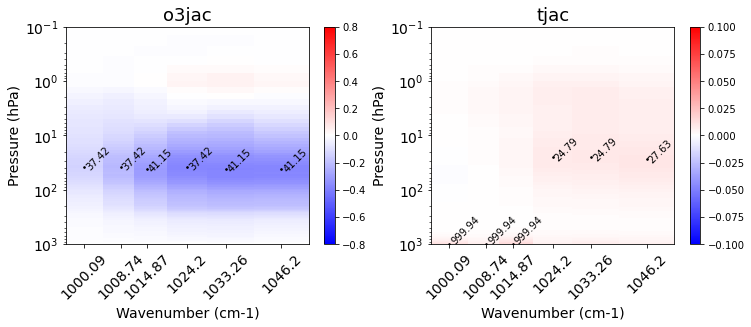

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flat

data = o3_channels

ax = axs[0]
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "o3jac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.8,
    vmax=0.8,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

ax = axs[1]
ax.set_ylim(1e-1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "tjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.1,
    vmax=0.1,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

# co2_channels["co2jac"].plot()

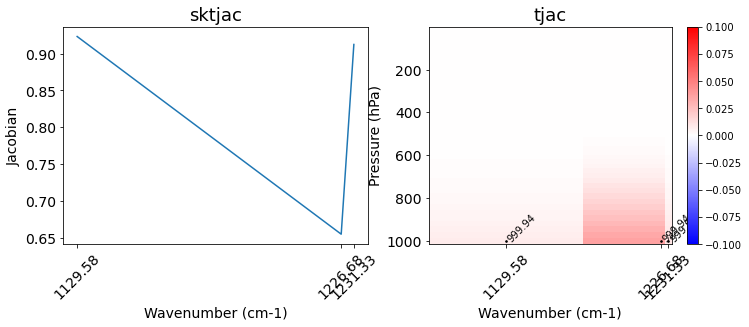

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flat

data = window_channels

ax = axs[0]
# ax.invert_yaxis()
var = "sktjac"
im = ax.plot(
    data[var].wnum,
    data[var],
)

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Jacobian", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)

ax = axs[1]
ax.invert_yaxis()
var = "tjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.1,
    vmax=0.1,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

# co2_channels["co2jac"].plot()

<xarray.DataArray 'play' (channel: 9)>
array([585.853638, 672.367126, 336.090912, 506.114746, 293.077209, 433.117401,
       366.78894 , 279.537384, 382.751526])
Coordinates:
    play     (channel) float64 585.9 672.4 336.1 506.1 ... 366.8 279.5 382.8
  * channel  (channel) int64 1697 1723 1805 1852 1862 1866 1937 2088 2138
    wnum     (channel) float64 1.33e+03 1.344e+03 ... 1.561e+03 1.596e+03
<xarray.DataArray 'play' (channel: 9)>
array([741.693481, 790.016113, 366.78894 , 585.853638, 336.090912, 506.114746,
       433.117401, 321.351074, 468.776917])
Coordinates:
    play     (channel) float64 741.7 790.0 366.8 585.9 ... 433.1 321.4 468.8
  * channel  (channel) int64 1697 1723 1805 1852 1862 1866 1937 2088 2138
    wnum     (channel) float64 1.33e+03 1.344e+03 ... 1.561e+03 1.596e+03


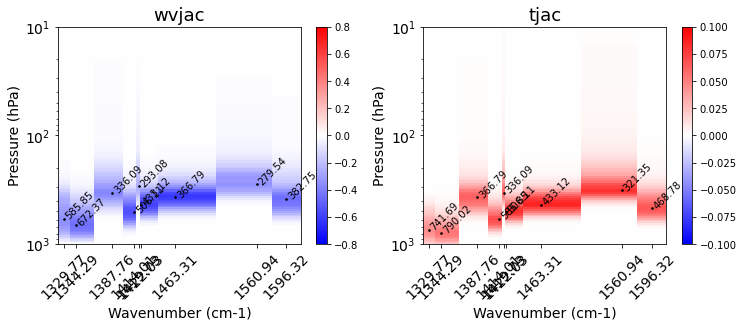

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flat

data = h2o_t_channels

ax = axs[0]
ax.set_ylim(1e1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "wvjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.8,
    vmax=0.8,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 
print(max_lev)
    
ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

ax = axs[1]
ax.set_ylim(1e1, 1e3)
ax.invert_yaxis()
ax.set_yscale('log')
var = "tjac"
im = ax.pcolormesh(
    data[var].wnum,
    data[var].play,
    data[var],
    cmap="bwr", #coolwarm
    vmin=-0.1,
    vmax=0.1,
)

max_lev = data["play"][np.abs(data[var]).argmax(dim="play")]
ax.scatter(max_lev.wnum, max_lev, s=2.5, color="black")

for _lev in max_lev: 
    ax.annotate(np.round(_lev.values,2), (_lev.wnum, _lev + 5), rotation=45) 
print(max_lev)

ax.set_xticks(data.wnum)
ax.set_xticklabels(np.round(data.wnum.values,2), rotation=45)
ax.set_xlabel("Wavenumber (cm-1)", fontsize=14)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(var, fontsize=18)
fig.colorbar(im, ax=ax)

# co2_channels["co2jac"].plot()

As a note, the first three channels here are CH4 and N2O sensitive

In [31]:
rttov_channels.channel.to_dataframe().to_csv("test")